# Import packages

In [1]:
import os
import sys
%matplotlib inline
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime

#to set unique date for outputs
calc_date = datetime.datetime.now()
date=calc_date.strftime('%Y-%m-%d')
#date=calc_date.strftime('%d-%m-%Y')
date = date.replace('-', '')

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300, dpi_save=300)

# input data and metadata

In [2]:
#data_path = '/lustre/scratch117/cellgen/team298/SharedFolders/ar32/YS/main_data_with_WE_added/A2_V7_scvi_V8_model_selected_raw_qc_scr_umap_with_broad_labels.h5ad'
#
#metadata_input = '' # leave blank if don't want to use
#
#adata = sc.read(data_path)
#
#if len(metadata_input) == 0:
#    pass
#else:
#    metadata = pd.read_csv(metadata_input, index_col=0)
#    adata = adata[adata.obs.index.isin(list(metadata.index))]
#    adata.obs = metadata

indexer = pd.read_csv('/lustre/scratch117/cellgen/team298/SharedFolders/YS_proj/Datasets/YS_datasets_indexer.csv', index_col=0)

keys = ['YS']

intersect_genes = False

adatas = {}
gene_intersect = []

for key in keys:
    adatas[key] = sc.read(indexer.loc[key]['Specific Directory'])
    adatas[key].var_names_make_unique()
    adatas[key].obs['celltypes_anno'] = adatas[key].obs[indexer.loc[key]['Main_anno_col']]
    
    if len(keys) == 1:
        adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],join='inner')
        print('Only one dataset selected from indexer, dataset loaded as: adata')
        break
    
    if key == keys[0]:
        gene_intersect = list(adatas[key].var_names)
    else:
        gene_intersect = [gene for gene in list(adatas[key].var_names) if gene in gene_intersect]   #set(list1).intersection(list2)
        if key == keys[-1]:  
            print('All datasets loaded under dictionary: adatas')
            
if intersect_genes == True:
    for dataset in adatas:
        adatas[dataset] = adatas[dataset][:,adatas[dataset].var_names.isin(gene_intersect)]

/home/jovyan/my-conda-envs/YS_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Only one dataset selected from indexer, dataset loaded as: adata


In [3]:
# Ammend old dictionary with new annotations for correct groups
Fig1d_dict_1 = {
'Cycling DC2': 'DC',
 'Mac DC2': 'DC',
 'Mono Mac DC2': 'DC',
 'Mono Mac pre DC2': 'DC',
 'Pre DC2': 'DC',
 'pDC precursor': 'DC',
 'Endoderm': 'Endoderm',
 'AEC': 'PLVAP+ Endothelium',
 'HE': 'PLVAP+ Endothelium',
 'Immature_EC': 'LYVE1+ Endothelium',
 'Prolif_AEC': 'PLVAP+ Endothelium',
 'Prolif_Sinusoidal_EC': 'LYVE1+ Endothelium',
 'Sinusoidal_EC': 'LYVE1+ Endothelium',
 'VWF_EC': 'PLVAP+ Endothelium',
 'Early_Erythroid': 'Erythroid',
 'Mid_Erythroid' : 'Erythroid', # new anno
 'Def_Erythroid' : 'Erythroid', # new anno
 'Erythroid': 'Erythroid',
 'Fibroblast': 'Fibroblast',
 'Eo_Baso_Mast_precursor': 'Granulocyte_precursors',
 'Eo_Basophil': 'Granulocyte_precursors',
 'Neutrophil_precursor': 'Granulocyte_precursors',
 'ILC_precursor': 'Lymphoid',
 'NK': 'Lymphoid',
 'Lymphoid B lin' : 'Lymphoid', # new anno
 'MK': 'MK',
 'Macrophage': 'Macrophage',
 'Pre_Macrophage': 'Macrophage',
 'Mast_cell': 'Mast_cell',
 'Mesothelium': 'Mesothelium',
 'Microglia': 'Microglia',
 'Monocyte_0': 'Monocyte',
 'Monocyte_Macrophage': 'Monocyte',
 'Monocyte_ys_1': 'Monocyte',
 'Promonocyte': 'Monocyte',
 'CMP': 'Progenitors',
 'HSPC_1': 'Progenitors',
 'HSPC_2': 'Progenitors',
 'LMPP': 'Progenitors',
 'Lymphoid_progenitor': 'Progenitors',
 'MEMP': 'Progenitors',
 'MOP': 'Progenitors',
 'Smooth_Muscle': 'Smooth_Muscle'}

adata.obs['Fig1d_1'] = adata.obs['cell.labels'].map(Fig1d_dict_1)
adata.obs['Fig1d_1'].value_counts(dropna=False)

Erythroid                 62664
Macrophage                44442
Fibroblast                28730
Endoderm                   7656
Smooth_Muscle              5106
Progenitors                4912
LYVE1+ Endothelium         4477
PLVAP+ Endothelium         3822
Mesothelium                2750
MK                         2044
DC                          643
Microglia                   613
Monocyte                    574
Lymphoid                    507
Mast_cell                   354
Granulocyte_precursors      200
Name: Fig1d_1, dtype: int64

In [4]:
# normalise count data
sc.pp.normalize_total(adata, target_sum=1e4)
# log the count data
sc.pp.log1p(adata) # note data isn't actually normalised
# scale the data
#sc.pp.scale(adata, max_value=10)

normalizing counts per cell
    finished (0:00:01)


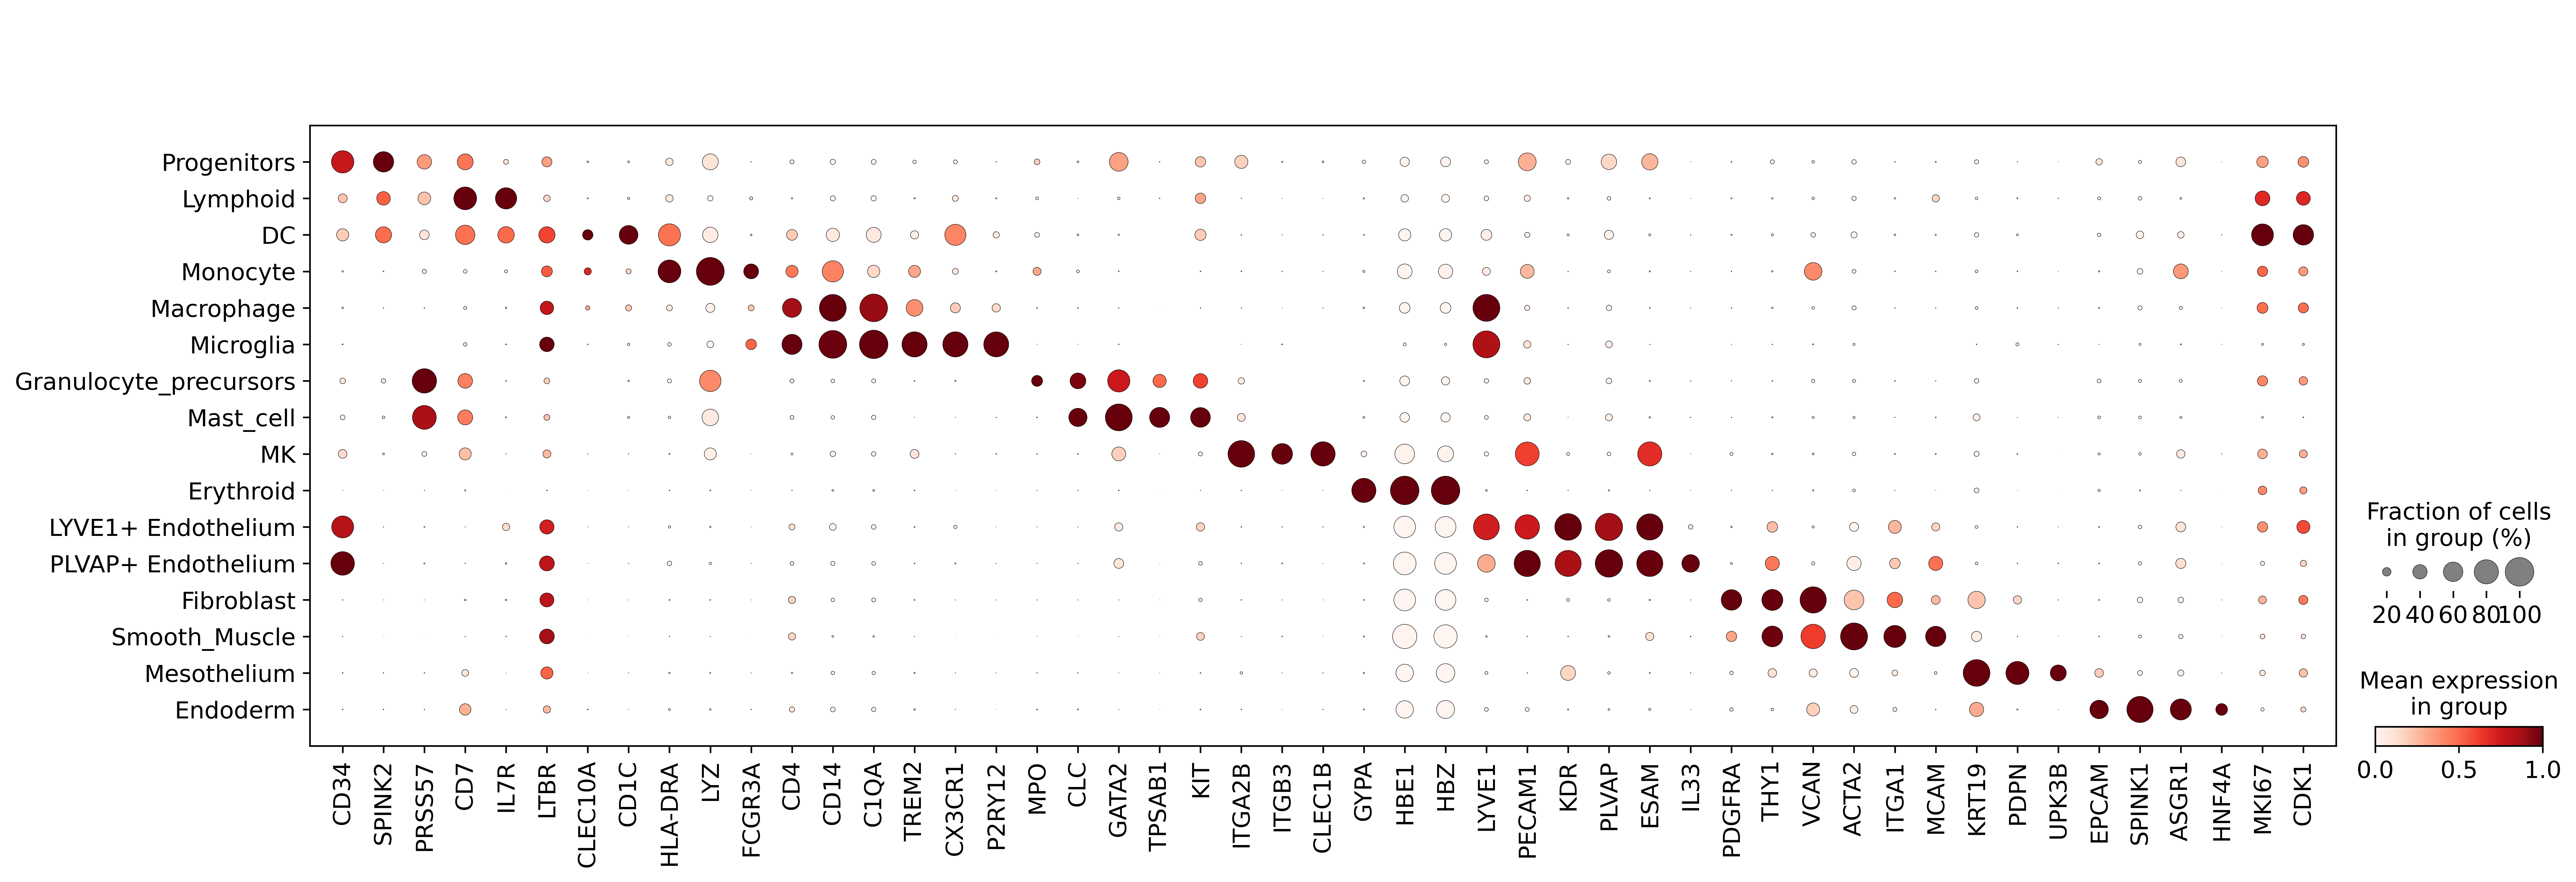

In [6]:
adata.obs["Fig1d_1"] = adata.obs["Fig1d_1"].astype('category')
adata.obs["Fig1d_1"] = adata.obs["Fig1d_1"].cat.reorder_categories([
'Progenitors',
'Lymphoid',
'DC',
'Monocyte',
'Macrophage',
'Microglia',
'Granulocyte_precursors',
'Mast_cell',
'MK',
'Erythroid',
'LYVE1+ Endothelium',
'PLVAP+ Endothelium',
'Fibroblast',
'Smooth_Muscle',
'Mesothelium',
'Endoderm'
])

gene_list2 = [
'CD34',
'SPINK2',
'PRSS57',
'CD7',
'IL7R',
'LTBR',
'CLEC10A',
'CD1C',
'HLA-DRA',
'LYZ',
'FCGR3A',
'CD4',
'CD14',
'C1QA',
'TREM2',
'CX3CR1',
'P2RY12',
'MPO',
'CLC',
'GATA2',
'TPSAB1',
'KIT',
'ITGA2B',
'ITGB3',
'CLEC1B',
'GYPA',
'HBE1',
'HBZ',
'LYVE1', # added in     
'PECAM1',
'KDR',
'PLVAP', # added in  
'ESAM', # added in
'IL33',
'PDGFRA',
'THY1',
'VCAN',
'ACTA2',
'ITGA1',
'MCAM',
'KRT19',
'PDPN',
'UPK3B',
'EPCAM',
'SPINK1',
'ASGR1',
'HNF4A', # added in
'MKI67',
'CDK1',
]

sc.pl.dotplot(adata, var_names=gene_list2, groupby='Fig1d_1', use_raw=False, standard_scale='var', save='YS_main_fig1d_{d}.pdf'.format(d=date)) 

# Protein 

In [ ]:
import os
import sys
%matplotlib inline
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300, dpi_save=300)

In [ ]:
# Read in processed DSB GMM YS Protein data 
adata = sc.read('/home/jovyan/YS_project/YS_CiteSeq_final_script_templates/protein_pipeline_19112021/Cite_seq_protein_processed_20220331.h5ad')

In [ ]:
gene_list1 = [
'CD34',
'CD7',
'CD127',
'LT_bR',
'CD301',
'CD1c',
'HLA_DR',
'CD16',
'CD4',
'CD14',
'CD117',
'CD41',
'CD61',
'CLEC1B',
'CD235a',
'CD31',
'CD309',
'CD90',
'CD49a',
'CD146',
'CD326'
]

sc.pl.dotplot(adata, var_names=gene_list1, groupby='broad_anno', standard_scale='var', use_raw=False, cmap='Blues')